# **Organizational Network Analysis**


## **Introduction**

Have you ever looked at an org chart at your company and realized that it doesn't actually represent how work gets done? Have you ever wondered what the reasons are for lack of collaboration between teams, or why it's hard for people to locate the knowledge they need to be successful at their jobs? What about measuring inclusion? Have you ever looked at the data in your models and wished for another set of data that could make your model more predictive?

Organizational Network Analysis (ONA) is a powerful tool that looks at the connections between people in organizations, and the reasons for those connections. 

There are multiple ways to collect network data—in this tutorial we'll focus on **survey data**. But many organizations also leverage passive data, such as data from email traffic, internal BBS systems (like Yammer), or even Sharepoint. One main advantage to survey data is that it allows us to directly observe multiple dimensions of relationships, such as trust, innovation, positive energy, and need for greater access, where email data can fall short in terms of measuring those kinds of dimensions. A disadvantage to survey data compared to passive data is that it is more costly to collect in terms of people's time. 

Despite the fact that ONA is gaining popularity in companies, it can raise eyebrows because of concerns over privacy and data usage. Just like for any analysis you conduct, **it is very important for you to consult with your employment law, compliance team, and/or project stakeholders** to agree upon what you're colleting, why you're collecting it, how you are processing the data, how you are storing the data, how you will communicate to participants, and how you will handle any problems that may arise as a result of the exercise. It is especially important that **you are transparent with participants** on those same points, in addition to explaining to them how the analysis you're performing benefits them. 

In this tutorial, we'll highlight ways of processing raw survey data, analyzing processed data, and visuzlizing processed data. 

Again, this is a **very** simplified tutorial. For now, this is a general overview that's hopefully useful to you to get started working with HR data.

<br>
<br>

**Note:**

`#` in the code blocks below denotes a comment that I have added for you to better understand what the code is saying/doing.



## **What data we need for a survey-based ONA**

In addition to **a data file from a completed survey**, we need information about the participants who took the survey (such as their job title, name, location, job level), as well as the people they identify as important to their work. This is known as the **attribute list**. 

For the sake of the exercise, we'll be dealing primarily with three sets of data. All data can be found in the `Sample ONA Data.xlsx` in the following worksheets:

-  `Raw Survey Data Output` - as the name suggests, this is an example of what a survey platform produces for you. This is synthetic data developed purely for the purpose of our meetup.
-  `Questionnaire Itens` - this is for reference purposes to know what the columns in the `Raw Survey Data Output` refer to
-  `Attribute Data from HRIS` - this is an example of an attribute list that your HRIS team may produce for you

Finally, within `Sample ONA Data.xlsx`, you'll see a worksheet called `Sample Filled-Out Quetionnaire` which gives you an idea of what a questionnaire looks like when it's filled out by a participant. We won't be reffering to this worksheet in this jupyter notebook tutorial.


## **Groundwork - loading relevant packages and data**

Like before, we'll use still use pandas (`pd`) and numpy (`np`). 

We'll also use the `networkx` package, which in our code we'll refer to as `nx`. Read more about the `networkx` library __[here](https://networkx.github.io/documentation/stable/)__. 

Finally, we'll definitely want to make some cool network graphs, and we should do that with `matplotlib`'s `.pyplot` sub-library, which we'll refer to as `plt`.  Read more about the `matplotlib` library __[here](https://matplotlib.org/index.html)__. 

In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

#note that we are using a google drive link to read in data-- this is the same "Sample ONA Data.xlsx" file in the './data/' folder!

#read in the raw survey data
raw_survey_dat = pd.read_excel('https://drive.google.com/uc?export=download&id=1VeFV6L7z8pMPwMmCBE8FZrIaV9-8yjUU',sheet_name='Raw Survey Data Output') #read in xlsx data 
#and specifically read in the worksheet called "Raw Survey Data Output"

#read in the questionnaire items that we can refer to later
survey_question_key=pd.read_excel('https://drive.google.com/uc?export=download&id=1VeFV6L7z8pMPwMmCBE8FZrIaV9-8yjUU',sheet_name='Questionnaire Items')

#read in attributes about the survey population
attribute_dat=pd.read_excel('https://drive.google.com/uc?export=download&id=1VeFV6L7z8pMPwMmCBE8FZrIaV9-8yjUU',sheet_name='Attribute Data from HRIS')

## **Understanding survey data outputs**

Different survey platforms will deliver data to you in different structures and formats. In this example, the data are delivered to you in a manner that's similar to how leading cloud survey platforms would structure the data. 

In [ ]:
raw_survey_dat.head() #let's take a look at the data

#note that each row is for one completed survey, and the columns mostly correspond to the questionnaire items

,participant_email,Q1,Q2,Q3,Q4,Q5_1,Q5_2,Q5_3,Q5_4,Q5_5,Q5_6,Q5_7,Q5_8,Q5_9,Q5_10,Q5_11,Q5_12,Q5_13,Q5_14,Q6_1,Q6_2,Q6_3,Q6_4,Q6_5,Q6_6,Q6_7,Q6_8,Q6_9,Q6_10,Q6_11,Q6_12,Q6_13,Q6_14,Q7_1,Q7_2,Q7_3,Q7_4,Q7_5,Q7_6,Q7_7,Q7_8,Q7_9,Q7_10,Q7_11,Q7_12,Q7_13,Q7_14,Q8
0,person.1@widgetcorp.com,New Project Launch,Sometimes,Knowing who does what,0.50,person.4@widgetcorp.com,person.5@widgetcorp.com,person.6@widgetcorp.com,person.7@widgetcorp.com,person.2@widgetcorp.com,person.3@widgetcorp.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,This survey is great
1,person.2@widgetcorp.com,New Project Launch,Always,Knowing who does what,0.75,person.4@widgetcorp.com,person.8@widgetcorp.com,person.9@widgetcorp.com,person.10@widgetcorp.com,person.11@widgetcorp.com,person.12@widgetcorp.com,person.1@widgetcorp.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1.0,NaN,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Everyone loves this survey
2,person.3@widgetcorp.com,New Project Launch,Never,Knowing who does what,0.75,person.4@widgetcorp.com,person.13@widgetcorp.com,person.14@widgetcorp.com,person.2@widgetcorp.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,person.4@widgetcorp.com,New Project Launch,Sometimes,Policies and Procedures,0.75,person.1@widgetcorp.com,person.2@widgetcorp.com,person.3@widgetcorp.com,person.5@widgetcorp.com,person.8@widgetcorp.com,person.13@widgetcorp.com,person.15@widgetcorp.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,person.5@widgetcorp.com,Fixing Technical Bugs,Sometimes,Policies and Procedures,0.50,person.1@widgetcorp.com,person.15@widgetcorp.com,person.6@widgetcorp.com,person.7@widgetcorp.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# the language used in the survey questions themselves isn't in this file. but fortunately 
#we have that saved out in the excel file just for the convenience of this exercise. 
survey_question_key

#So when we look at Q5_1 through Q5_X in the raw survey data, we see that each one of the 
#columns represents people that are important to the participant. 
#Similarly Q6_X and Q7_X correspond to those important people who the
#particcipant needs more access to to be more effective in their job, 
#or who are a source of positive energy to the participant in work/collaboration

,Unnamed: 0,Question,Choices,Question Type
0,Q1,What is the most pressing goal facing our comp...,1) Fixing bugs in existing products; 2) Launch...,Non-Network Question
1,Q2,To what extent do you agree with the following...,Never; Sometimes; Always,Non-Network Question
2,Q3,What kind of information is the most difficult...,Policies and Procedures; Knowing who does what,Non-Network Question
3,Q4,Approximately How much of your time do you spe...,0%; 25%; 50%; 75%; 100%,Non-Network Question
4,Q5,Who is important to your work at widgetcorp? L...,List up to 14 colleagues at widget corp.,Network Question
5,Q6,Provides me with client information,Checkbox for each colleague listed in question 5,Network Question
6,Q7,Has creative discussions with me,Checkbox for each colleague listed in question 5,Network Question
7,Q8,Please provide any other comments you'd like t...,Free-response,Non-Network Question


### **Processing survey data for analysis**


#### **Working with the response data**
We need to reshape our data, however, to get it into a more usable format where we can do quick counts 
(like what we demo'ed in the previous sections) and in a format that the networkx package can quickly work with.

In [ ]:
#first, let's make lists of our network and non-network questions 
non_network_questions=['Q1','Q2','Q3','Q4','Q8'] #let's make a list of non_network questions for analysis later, 
                                                 #since they should be handled differently than we handle network data

network_questions = list(set(raw_survey_dat.columns)-set(non_network_questions)) #this gets the differences 
                                                                                 #lists

#next, let's make separated datasets for network and non-network questions
raw_survey_dat_non_network_questions=raw_survey_dat[non_network_questions]

raw_survey_dat_network_questions=raw_survey_dat[network_questions]

network_data_reshaped=pd.wide_to_long(raw_survey_dat_network_questions, 
                                      stubnames=['Q5_','Q6_','Q7_'], #here are the variables we want to put into one single column
                                      i='participant_email', #this is what we pivot on
                                      j='alter_number') #this creates a new variable after 'reshaping'

#some of our participants didn't have as many as 14 people listed as important to their work, 
#so let's drop records where no one is listed as important
network_data_reshaped=network_data_reshaped[~pd.isna(network_data_reshaped['Q5_'])]

network_data_reshaped.head() #let's take a look at the data

#note how after the reshape there are multiple 'levels' of columns and 'participant emails' are merged together. 
#we'll correct for this below

Q5_  Q6_  Q7_
participant_email        alter_number                                   
person.10@widgetcorp.com 1             person.2@widgetcorp.com  NaN  1.0
                         2             person.9@widgetcorp.com  1.0  1.0
person.11@widgetcorp.com 1             person.2@widgetcorp.com  NaN  1.0
                         2             person.9@widgetcorp.com  1.0  1.0
person.12@widgetcorp.com 1             person.5@widgetcorp.com  NaN  1.0

In [ ]:
#Finally, let's make sure we have just the columns we need with readable names,
#and let's correct for the merging and column leveling we see above

#this let's first correct for the column releveling and cell merging we saw above
network_data_reshaped=network_data_reshaped.reset_index() 

#now rename columns to a more 'readable' format
network_data_reshaped.rename(columns={'participant_email':'ego', #ego means 'self' - this is the person reaching out
                                      'Q5_':'alter', #this is the person being sought by the 'ego' (or respondent)
                                      'Q6_':'Client Information',
                                      'Q7_':'Creative Discussions'},
                             inplace=True) 

network_data_reshaped=network_data_reshaped.drop(columns='alter_number') #we don't need the 'alter_number' column

network_data_reshaped=network_data_reshaped.sort_values(by='ego') #let's sort the data to make it easy on the eyes

network_data_reshaped.head() #let's take a look at the data

,ego,alter,Client Information,Creative Discussions
0,person.10@widgetcorp.com,person.2@widgetcorp.com,NaN,1.0
1,person.10@widgetcorp.com,person.9@widgetcorp.com,1.0,1.0
2,person.11@widgetcorp.com,person.2@widgetcorp.com,NaN,1.0
3,person.11@widgetcorp.com,person.9@widgetcorp.com,1.0,1.0
4,person.12@widgetcorp.com,person.5@widgetcorp.com,NaN,1.0


#### **Attaching attribute information**
Next we need to attach attribute data to both the ego and alter for quick calculations later. This can be done with a quick merge, but with a little pre-work to change variable names


In [ ]:
#make a copy of the attribute data to attach to the egos
ego_attribute_data=pd.DataFrame(attribute_dat)

#rename columns that we'll attach to our reshaped network data
ego_attribute_data=ego_attribute_data.rename(columns={'email':'ego', 
                                      'Title':'ego_title', 
                                      'Team':'ego_team',
                                      'Manager Status':'ego_manager_status',
                                      'Location':'ego_location'})

network_data_reshaped=pd.merge(network_data_reshaped,
                               ego_attribute_data,
                               on='ego',
                               how='left')
                             
#make a copy of attribute data to attach to the egos
alter_attribute_data=pd.DataFrame(attribute_dat)

alter_attribute_data=alter_attribute_data.rename(columns={'email':'alter', 
                                      'Title':'alter_title', 
                                      'Team':'alter_team',
                                      'Manager Status':'alter_manager_status',
                                      'Location':'alter_location'})

network_data_reshaped=pd.merge(network_data_reshaped,
                               alter_attribute_data,
                               on='alter',
                               how='left')

network_data_reshaped.to_csv('./edge_list_with_attributes_attached.csv')
#now we are ready to run some cross tabs and aggregations on a bunch of dimensions!

network_data_reshaped.head() #let's take a look at our data



,ego,alter,Client Information,Creative Discussions,ego_title,ego_team,ego_manager_status,ego_location,alter_title,alter_team,alter_manager_status,alter_location
0,person.10@widgetcorp.com,person.2@widgetcorp.com,NaN,1.0,NaN,Technology,Individual Contributor,Satellite Office 1,CTO,Technology,Executive,Headquarters
1,person.10@widgetcorp.com,person.9@widgetcorp.com,1.0,1.0,NaN,Technology,Individual Contributor,Satellite Office 1,NaN,Technology,Individual Contributor,Headquarters
2,person.11@widgetcorp.com,person.2@widgetcorp.com,NaN,1.0,NaN,Technology,Individual Contributor,Satellite Office 2,CTO,Technology,Executive,Headquarters
3,person.11@widgetcorp.com,person.9@widgetcorp.com,1.0,1.0,NaN,Technology,Individual Contributor,Satellite Office 2,NaN,Technology,Individual Contributor,Headquarters
4,person.12@widgetcorp.com,person.5@widgetcorp.com,NaN,1.0,NaN,Technology,Individual Contributor,Satellite Office 2,NaN,Finance,Management,Headquarters




### **Influential Colleagues**

There are many ways people can be influential in networks. In this example we think of who is the most influential based on how many people seek out an employee/say that person is important to them at work.

Let's also make a numeric representation of this idea.

In [ ]:
#For this, let's do a quick value count using Pandas
#We'll count the number of times someone says that a given person is important to them at work

inbound_connections=pd.DataFrame(network_data_reshaped.groupby('alter').size()) #we are putting this groupby count into a dataframe for later

inbound_connections=inbound_connections.reset_index()
inbound_connections.columns=['alter','Inbound Connections'] #we need to rename the count to something more intuitive 
inbound_connections=inbound_connections.sort_values('Inbound Connections',ascending=False) #we'll sort to see the most influential on top

inbound_connections.head()
#We can see here specifically how many people seek out each person in the network- 
#again person 9 is highly sought

,alter,Inbound Connections
14,person.9@widgetcorp.com,9
5,person.15@widgetcorp.com,7
7,person.2@widgetcorp.com,7
3,person.13@widgetcorp.com,5
6,person.1@widgetcorp.com,5


### **Under-sought colleagues**

Conversely, let's look at those who are undersought-- these are colleagues that may be at risk for attrition or may need extra help getting onboarded/integrated into the organization. 

Let's also make a numeric representation of this idea.

In [ ]:
inbound_connections=inbound_connections.sort_values('Inbound Connections',ascending=True) #we simply reverse the sort on  the data on number of incoming tie counts

inbound_connections.head()

,alter,Inbound Connections
0,person.10@widgetcorp.com,1
2,person.12@widgetcorp.com,2
1,person.11@widgetcorp.com,3
4,person.14@widgetcorp.com,3
9,person.4@widgetcorp.com,3



### **Cross-team connectivity**

A common way to look at connectivity across teams is to look at the number of connections to other groups as a percentage of a group's all outgoing connections. This is refered to as a block density chart (though there are other ways to calculate block densities that we will not cover here). 

In [ ]:

#for this, we'll use the .crosstab function
team_block_density=pd.crosstab(index=network_data_reshaped['ego_team'],
                               columns=network_data_reshaped['alter_team'],
                               normalize='index') # this divides the number of connectins by all

team_block_density*100 # here we see that most groups' reach out to themselves for work (looking at the diagnols)
                        #at this point, we might ask managers if business goals require collaboration across groups

alter_team,CEO,Finance,Sales,Technology
ego_team,,,,
CEO,0.000000,28.571429,42.857143,28.571429
Finance,5.000000,60.000000,20.000000,15.000000
Sales,5.555556,0.000000,61.111111,33.333333
Technology,5.263158,10.526316,10.526316,73.684211


### **Visualizing the network**

Another way to analyze the work between groups is to visualize the entire network graph. 

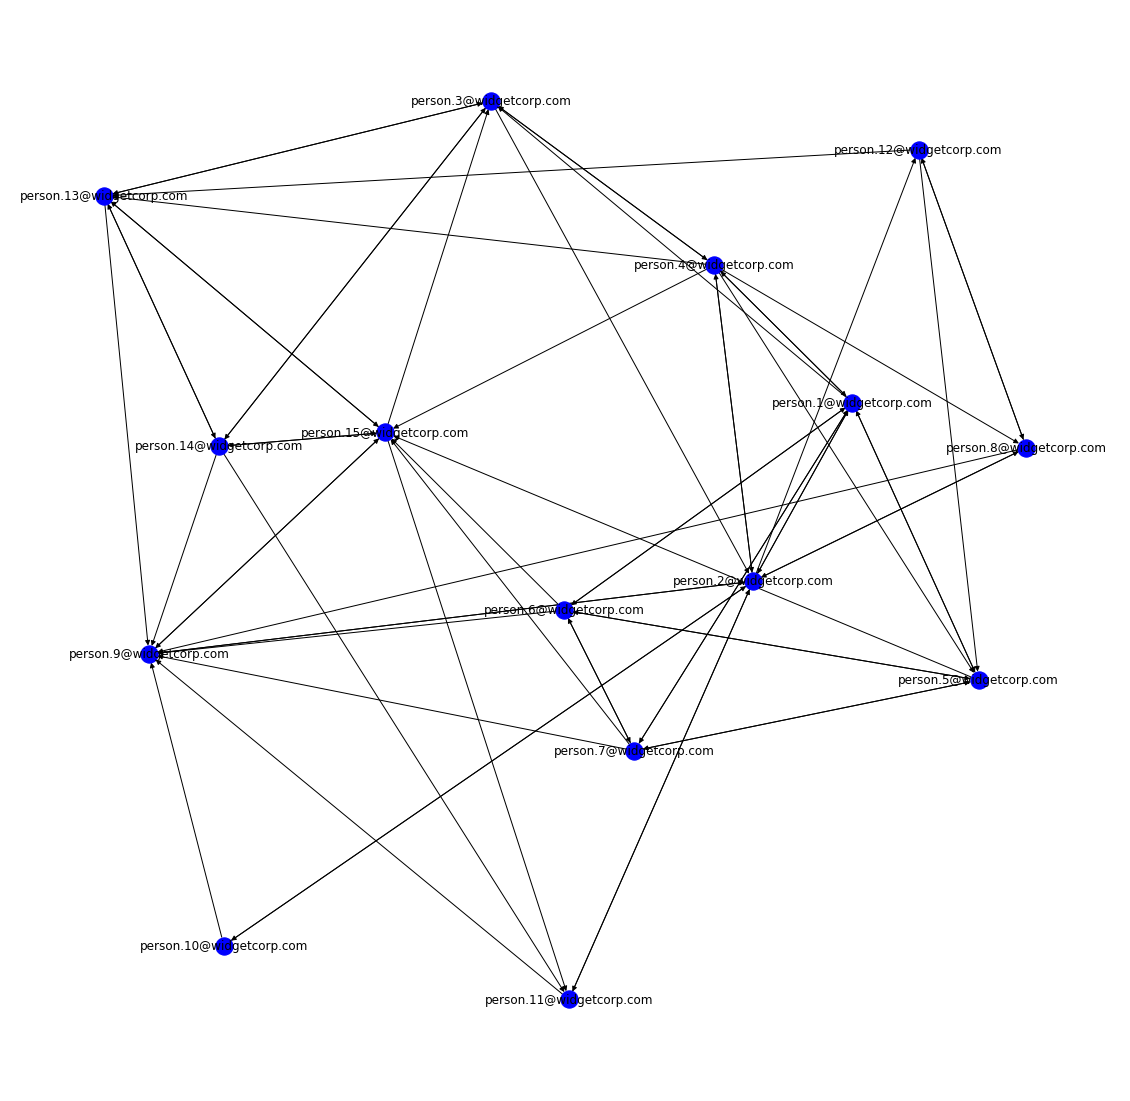

In [ ]:
#first, we need to generate a "graph" from the data using the networkx package 'nx'

network_graph=nx.from_pandas_edgelist(network_data_reshaped, 
                                      source='ego', 
                                      target='alter',
                                      create_using=nx.DiGraph()) #this tells networkx that the graph is directed
                                                                 #meaning people can seek out and also be sought

#now let's tell python to generate a visual.

plt.figure(figsize=(20,20)) #we want to change matplotlib's default plotting size
limits=plt.axis('off') #this turns off axes in the graph
nx.draw_networkx(network_graph,
                 arrows=True,
                 node_color='b') 

#this is a good, though we probably need to change a few things about the nodes (like their color and size)
#to tell a slightly better story.

In [ ]:
#let's size each node according to how many people seek that person. 
# this is called indegree centrality (and is the same concept as in the above section of "influential colleagues")
d = dict(network_graph.in_degree())

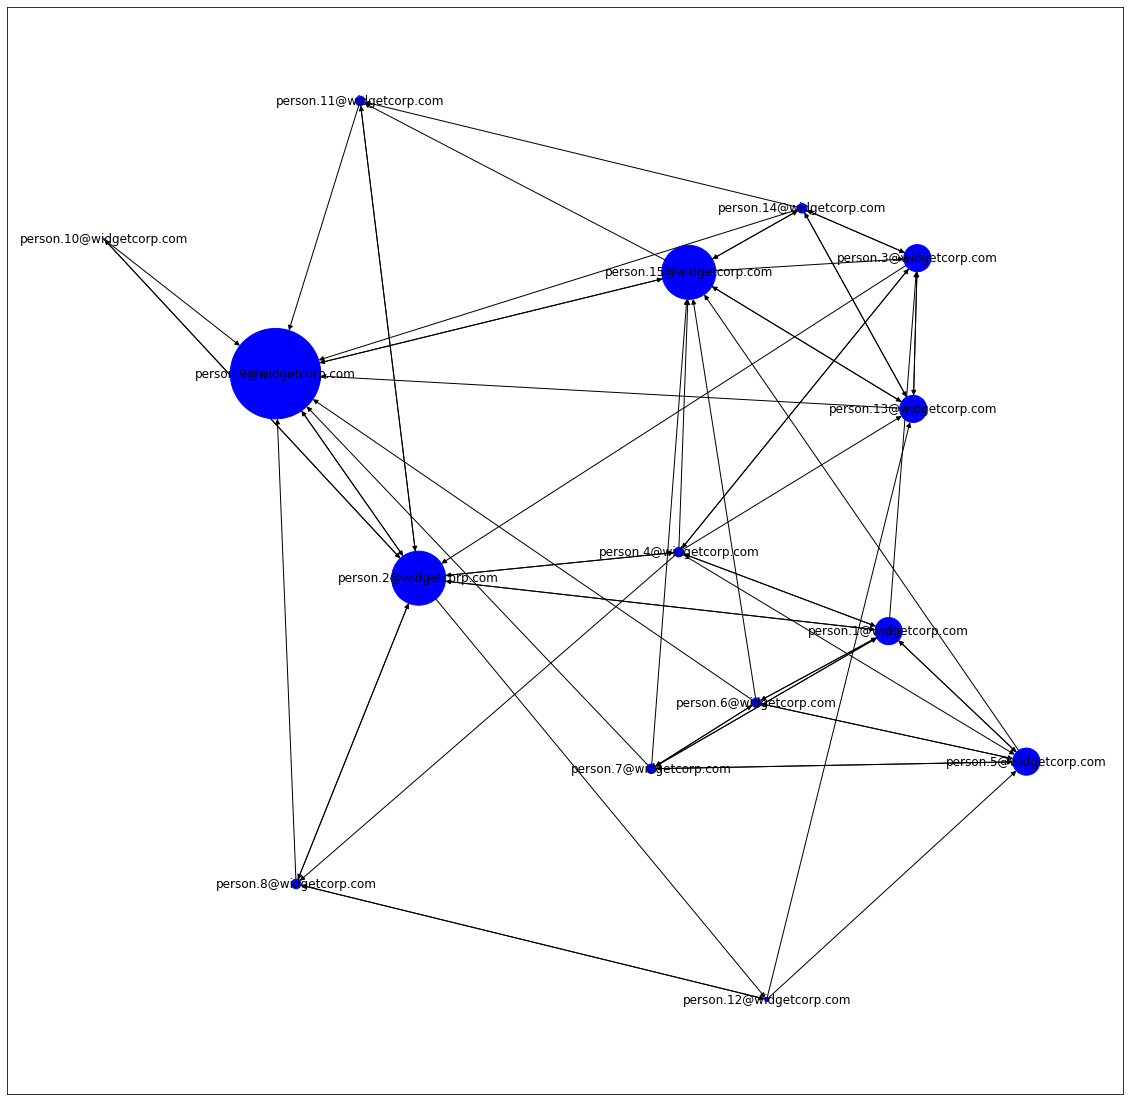

In [ ]:
#now let's re-draw the graph
plt.figure(figsize=(20,20)) #we want to change matplotlib's default plotting size
nx.draw_networkx(network_graph,
                 arrows=True,
                 node_color='b',
                 node_size= [v**4.1  for v in d.values()]) 

In [ ]:
#now let's re-draw the graph with the colors by department to see how departments are collaborating and who is the
#most influential

#first, we need to make a 'color key' for networkx to work with
 
# the below is custom code to get color codes for each node that corresponds to the Team they are on 
attribute_dat= attribute_dat.set_index('email')
attribute_dat=attribute_dat.reindex(network_graph.nodes())
attribute_dat['Team']=pd.Categorical(attribute_dat['Team'])
attribute_dat['Team'].cat.codes

email
person.10@widgetcorp.com    3
person.2@widgetcorp.com     3
person.9@widgetcorp.com     3
person.11@widgetcorp.com    3
person.12@widgetcorp.com    3
person.5@widgetcorp.com     1
person.8@widgetcorp.com     3
person.13@widgetcorp.com    2
person.3@widgetcorp.com     2
person.14@widgetcorp.com    2
person.15@widgetcorp.com    2
person.1@widgetcorp.com     1
person.4@widgetcorp.com     0
person.6@widgetcorp.com     1
person.7@widgetcorp.com     1
dtype: int8

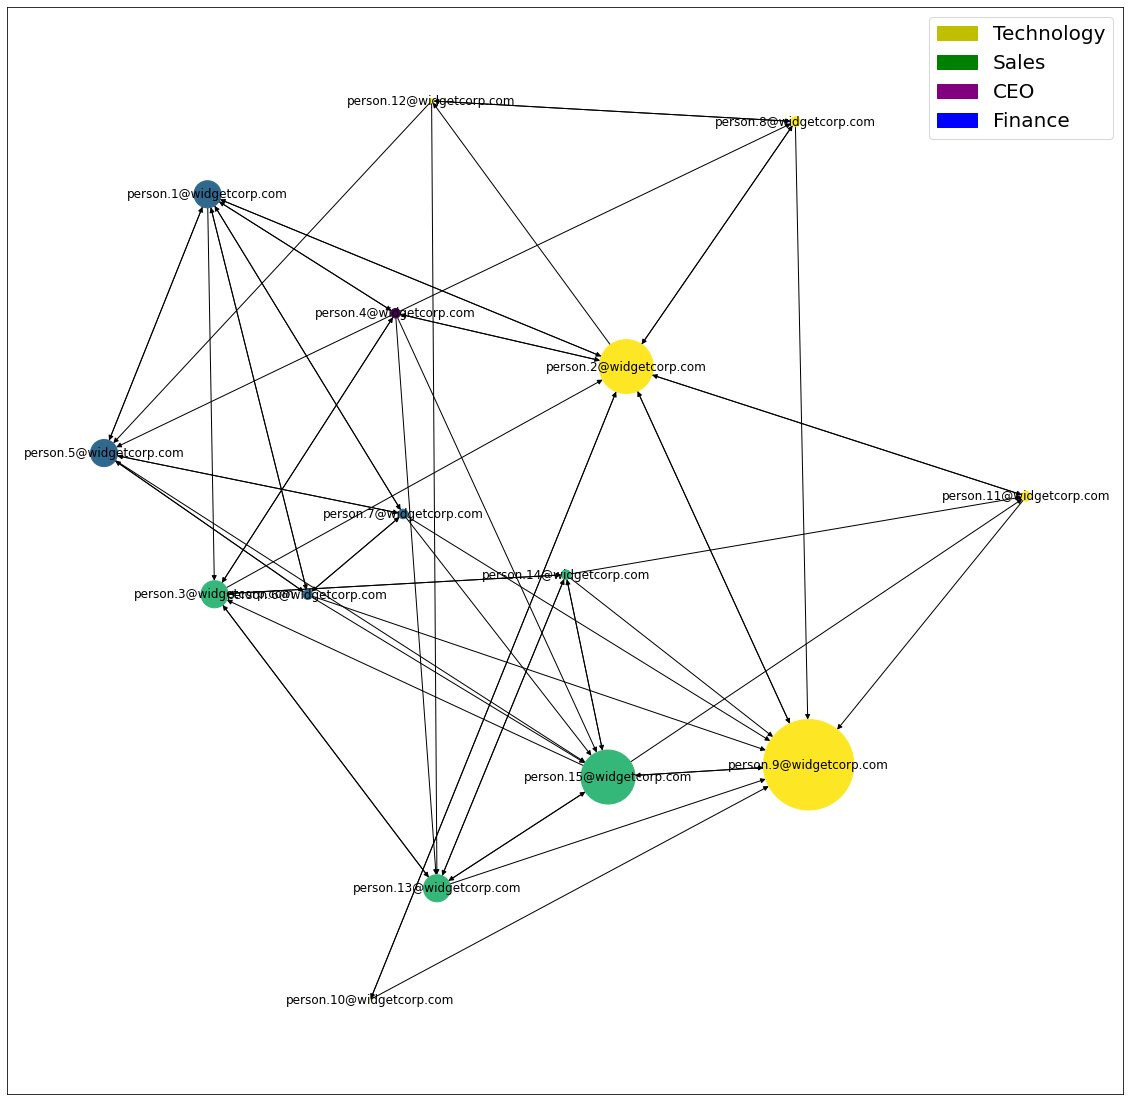

In [ ]:
plt.figure(figsize=(20,20)) #we want to change matplotlib's default plotting size
nx.draw_networkx(network_graph,
                 arrows=True,
                 node_color=attribute_dat['Team'].cat.codes,
                 node_size= [v**4.1 for v in d.values()]) 

#the below is custom code we won't cover in detail in our meetup that makes a legend
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = [Patch(facecolor='y', edgecolor='y',label='Technology'),
                   Patch(facecolor='g', edgecolor='g',label='Sales'),
                   Patch(facecolor='purple', edgecolor='purple',label='CEO'),
                   Patch(facecolor='b', edgecolor='b',label='Finance')]

plt.legend(handles=legend_elements,prop={'size': 20})
#here we can see that person 9, person 15, and person 2 pull a lot of influence in the company


### **Useful links**

##### General Resources
- __[Awesome Network Analysis](https://github.com/briatte/awesome-network-analysis#datasets)__ is a mega-repository of information on network theory, examples of network studies, code, datasets, ethics guidelines and much much more.
- __[The Connected Commons](https://connectedcommons.com/)__ A consortium of companies and acadmemics advancing network thinking in organizations worldwide.
- __[Analyzing Social Networks](https://www.amazon.com/Analyzing-Social-Networks-Stephen-Borgatti/dp/1446247414)__ A useful overview of Social Network Analysis. Teaches theory, study design, fundamental analytics, and advanced analytics. 

#### Analyzing network data outside of Python
- __[Gephi](https://gephi.org/)__ A free and open-source network visualization tool
- __[UCINET](https://sites.google.com/site/ucinetsoftware/home)__ An inexpensive network visualization and analytics tool popular among Connected Commons members. 

